# Homework 4


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import os.path
from os.path import exists
import os

from sklearn.decomposition import PCA

import time
import numpy as np
import h5py
import urllib.request

device="cpu"
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    device="cuda:0"
print(device)    

cpu


## Problem 1 (40 points): Revisiting our CNN from lecture

Let's revisit the CNN notebook that we worked through in class, and modify the code there to do something slightly different.

First, let's import our data:

In [2]:
output = 'ising_data.npz'

if not exists(output):
    import gdown
    url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1Ihxt1hb3Kyv0IrjHlsYb9x9QY7l7n2Sl"
    gdown.download(url, output, quiet=True)

f = np.load(output, allow_pickle=True)
n_train = 20000
n_test=len(f["C"])-n_train

x_train, x_test = f["C"][:n_train], f["C"][n_train:]
y_train, y_test = f["T"][:n_train], f["T"][n_train:]

x_train_tensor=torch.tensor(x_train,dtype=torch.float).unsqueeze(1)
y_train_tensor=torch.tensor(y_train,dtype=torch.float).unsqueeze(1)

x_test_tensor=torch.tensor(x_test,dtype=torch.float).unsqueeze(1)
y_test_tensor=torch.tensor(y_test,dtype=torch.float).unsqueeze(1)

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)

torch.manual_seed(123)

In the CNN lecture notebook, we used a CNN to predict whether the image had crossed the phase transition boundary or not.  What I'd like to do is a followup that I may have mentioned in lecture: let's use the CNN to predict the temperature that corresponds to the image, instead of a binary "yes/no" decision.  Some things to consider:

* What should the loss function be?

**Now your job**: setup and train a CNN that predicts the temperature associated with each image.  Here are some requirements, which may be different from what was done in the CNN notebook in class:

* Have the first convolutional layer use 16 filters
* Have the second convolutional layer use 32 filters
* Have the fully-connected part at the end include two layers with 32 nodes
* Use the `Adam` optimizer with a learning rate of 0.01
* Run for 10 epochs


As part of this problem, you should produce:
* The normal loss plot showing the training and test losses vs the number of epochs
* Once the network is trained, pass the test data through the network again, and get the predicted values.  Compare the predicted values with the true values; plot the difference and find the bias and variance of the network.

Some hints:
* You don't necessarily need to run the code for the full 16+32 convolutional filter network every time, the training takes a little while!  Feel free to debug with smaller numbers of filters.
* However, the setup is a bit delicate, so even small changes in the hyperparameters specified above may cause the training to not converge.

In [3]:
# code for creating the neural net

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # two convolutional layers
        self.conv1 = torch.nn.Conv2d( 1, 16, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # fully connected layer
        self.fc1 = torch.nn.Linear(32, 32)
        self.fc2 = torch.nn.Linear(32, 1)

    # x represents our data
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        # Run max pooling over x
        # x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = F.relu(x)

        # the (1,1) makes this into global average pooling
        x = F.adaptive_avg_pool2d(x,(1,1))
    
        # Flatten x with start_dim=1, i.e. only keep one number per channel per event.
        x=torch.flatten(x,1)
      
        # Pass data through the fully connected layer.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

In [4]:
# create the net, define the loss fuction and optimizer
net = Net()
print(net)
print(np.sum([np.prod(theta.shape) for theta in net.parameters()]))

torch.save(net.state_dict(), 'net4.pth') # saving the network

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)
5889


In [5]:
# train the net
torch.manual_seed(123)
net.load_state_dict(torch.load('net4.pth'))

losses = []
losses_test = []

loader = torch.utils.data.DataLoader(xy_train, batch_size=int(len(x_train)/5), shuffle=True)

for epoch in range(10):
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss=loss_fn(y_pred, y_test_tensor)
    losses_test.append(test_loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch} in {elapsed_time: .1f}, Train loss = {loss.data}, Test loss = {test_loss.data}")

Completed epoch 0 in  45.8, Train loss = 2.3002748489379883, Test loss = 1.5244274139404297
Completed epoch 1 in  42.7, Train loss = 1.017330288887024, Test loss = 0.9424647688865662
Completed epoch 2 in  41.2, Train loss = 0.2606782913208008, Test loss = 0.3697756230831146
Completed epoch 3 in  42.4, Train loss = 0.08540231734514236, Test loss = 0.07900891453027725
Completed epoch 4 in  43.4, Train loss = 0.09860269725322723, Test loss = 0.06215841695666313
Completed epoch 5 in  41.1, Train loss = 0.09777995198965073, Test loss = 0.07643193006515503
Completed epoch 6 in  39.0, Train loss = 0.07148706167936325, Test loss = 0.0752793699502945
Completed epoch 7 in  41.7, Train loss = 0.0520084910094738, Test loss = 0.0590057373046875
Completed epoch 8 in  42.1, Train loss = 0.04663555696606636, Test loss = 0.05109166353940964
Completed epoch 9 in  42.0, Train loss = 0.04838990047574043, Test loss = 0.04741393029689789


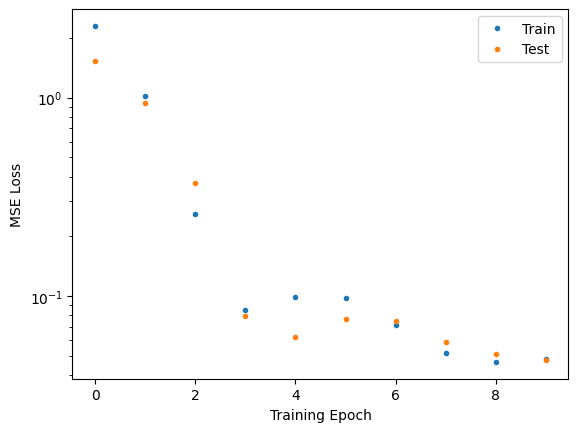

In [6]:
# plot the losses'
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log')

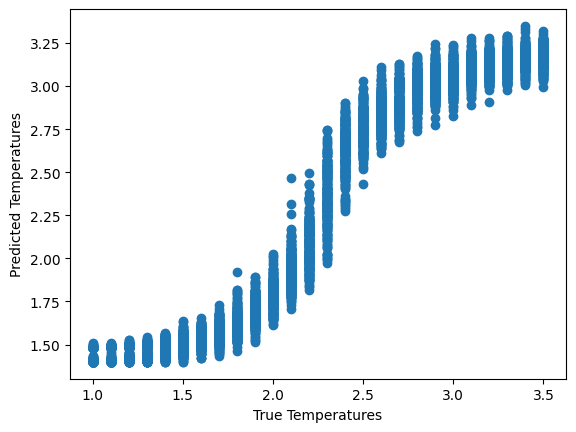

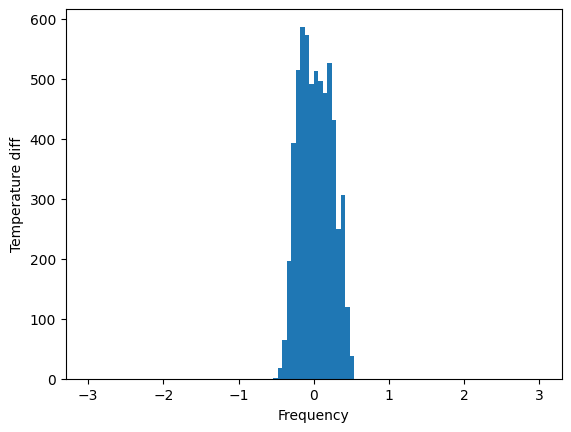

Bias (mean of the differences) = 0.028266
Variance = 0.046615


In [7]:
# evaluate and plot the losses for individual training dataset events
net.eval()
y_pred = np.array(net(x_test_tensor).data.flatten())

diff = y_pred - y_test

plt.scatter(y_test, y_pred)
plt.xlabel('True Temperatures')
plt.ylabel('Predicted Temperatures')
plt.show()

plt.hist(diff,bins=100,range=[-3,3])
plt.xlabel("Frequency")
plt.ylabel('Temperature diff')
plt.show()

print("Bias (mean of the differences) = %f" % np.mean(diff))
print("Variance = %f" % np.var(diff))

## Problem 2 (20 points): Principal Components Analysis

Let's perform a PCA test on some input data that we'll use for Problem #3.

First let's get some training and test datasets that we can use...  we'll start with one of the files that we used from HW3:

In [8]:
def clean_sample(sample):
    events=[]
    for i in sample:
        if i[0]>2:
            events.append(i)
    return events

def get_sample_from_URL(samplename,branches):
    
    if not os.path.isfile(samplename):
        urllib.request.urlretrieve("http://mhance.scipp.ucsc.edu/%s" % samplename, samplename)

    alldata=None
    with h5py.File(samplename,'r') as hdf5file:
        data=hdf5file[list(hdf5file.keys())[0]]["lowleveltree"]
        num_backgr_events=len(data["numjet"])
        alldata = data[branches]    

    Alldata=[[float(i) for i in j] for j in alldata]
    Alldata_clean=clean_sample(Alldata)
    return Alldata_clean

In [9]:
# now scale based on the training data:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

branches=("numjet","numlepton","numbtagjet",
          "met","metphi",
          "jet1pT", "jet1eta", "jet1phi","jet1b",
          "jet2pT", "jet2eta", "jet2phi","jet2b",
          "jet3pT", "jet3eta", "jet3phi","jet3b")

traindata=get_sample_from_URL('lowlevelAna_ttbar.hf5',branches)
x_train = sc.fit_transform(traindata)
train=torch.tensor(x_train,dtype=torch.float)

testdata=get_sample_from_URL('lowlevelAna_test.hf5',branches)
x_test = sc.transform(testdata)
test=torch.tensor(x_test,dtype=torch.float)

Using the `scikit-learn` PCA tool, analyze the `ttbar` dataset (`x_train`) retrieved above.

* Find the number of components needed to explain 50% of the variance.
* List the magnitudes of that number of leading eigenvalues, as a fraction of the total variance they capture

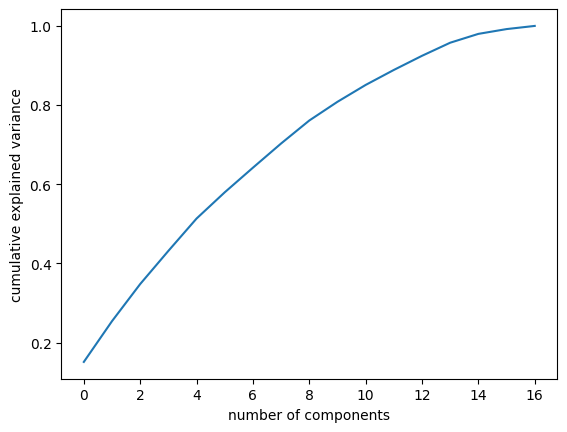

Explanied variance array: [0.15115807 0.2541584  0.3479097  0.43165682 0.51334968 0.57964796
 0.64179913 0.70299069 0.76102156 0.8083036  0.85089644 0.88876157
 0.92450541 0.95757566 0.97989425 0.99199516 1.        ]

Eigenvalues array: [2.56995717 1.75118951 1.59393955 1.42385066 1.3889244  1.12718927
 1.05668078 1.04036593 0.98662837 0.80387912 0.72415432 0.64377485
 0.60770917 0.56225322 0.37945587 0.20573718 0.13609652]

Eigenvalues over variance array: [0.15115807 0.10300033 0.0937513  0.08374712 0.08169285 0.06629829
 0.06215116 0.06119157 0.05803087 0.04728204 0.04259284 0.03786513
 0.03574384 0.03307024 0.02231859 0.01210092 0.00800484]

eigenvalue/variance for leading eigenvalue 0 = 0.15115807160700936
eigenvalue/variance for leading eigenvalue 1 = 0.10300032716856582
eigenvalue/variance for leading eigenvalue 2 = 0.09375130117933773
eigenvalue/variance for leading eigenvalue 3 = 0.08374712310181279
eigenvalue/variance for leading eigenvalue 4 = 0.0816928532451198


In [10]:
# your code here

pca = PCA().fit(train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()
print(f'Explanied variance array: {np.cumsum(pca.explained_variance_ratio_)}')
print()
# From the output array it can be seen that 5 components (0th component counted as 1st) are needed to explain >= 50% of the variance

eigenval = pca.explained_variance_
print(f'Eigenvalues array: {eigenval}')
print()

var = np.sum(eigenval)
frac = eigenval/var
print(f'Eigenvalues over variance array: {frac}') # same as explained_variance_ratio as required.
print()

# first 5 componets are 
for i in range(5):
    print(f'eigenvalue/variance for leading eigenvalue {i} = {frac[i]}')

## Problem 3 (40 points): AutoEncoders for Anomaly Detection

We discussed the use of AutoEncoders for de-noising, let's also look at AutoEncoders in the context of anomaly detection.  The goal will be to use an AutoEncoder to find "anomalies" in a data sample without knowing what those anomalies are.  We'll do this by training the network on an un-labeled data sample (i.e. unsupervised learning) and then using the trained network to evaluate a test dataset that has anomalies included.  The anomalies should show up as events with large loss values.

For this problem, we'll use the `ttbar` dataset from problem 2 for training, and the `testdata` dataset from problem 2 for testing.

**Your job**: Define our AutoEncoder, following the scheme we used in the AutoEncoder notebook in class, with the following changes:

* The number of input variables should be the number of variables needed to explain 50% of the variance in the `ttbar` sample (see solutions to Problem 2, let's call this number N_50).
* Use the `LeakyReLU` activation function, with args = `(0.2,inplace-True)`
* The encoder should have three layers:  (1) the input layer, with N nodes; (2) a hidden layer with 2\*N nodes; (3) a hidden layer with 10 nodes; (4) the latent-space layer, with N_50 nodes.
* Make sure to not define an activation on the last layer!



In [11]:
# your code here

class AutoEncoder(nn.Module):
    def __init__(self,n):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
                torch.nn.Linear(n, 2*n),
                torch.nn.LeakyReLU(0.2, inplace=True),
                torch.nn.Linear(2*n, 10),
                torch.nn.LeakyReLU(0.2, inplace=True),
                torch.nn.Linear(10, 5),
                torch.nn.LeakyReLU(0.2, inplace=True),
                torch.nn.Linear(5, 5), # latent space layer
                )
            
        self.decoder = nn.Linear(5, n)
        self.data_rho=None

    def forward(self, x):
        x = self.encoder(x)
        self.data_rho = x.mean(0)
        x = self.decoder(x)
        x = torch.sigmoid(x)
        return x  

Now train the autoencoder on the training data.  Run for 1500 epochs, using the `Adam`optimizer with a learning rate of 0.01.  Afterwards:
* Make a plot of the loss function vs epochs for the training data
* Make a plot of the loss *values* for all events in the training dataset.  This means passing single events into the loss function, instead of entire tensors!
* Now put the net into evaluation mode, and pass the test dataset through the network.  Make the same plot of loss values for all events in the test dataset.  
* Make a single plot that includes both histograms: the training set, and the testing set.

The difference between the training data and the test data can be subtle unless you overlay them, and (hopefully) see that there are more events in the large-loss tail of the test distribution than the training distribution!

In [12]:
# training loop

net = AutoEncoder(5)
print(net)
torch.save(net.state_dict(), 'net4Auto.pth') # saving the network
net.load_state_dict(torch.load('net4Auto.pth'))

pca = PCA(5)
train = torch.tensor(pca.fit_transform(x_train),dtype=torch.float)

test = torch.tensor(pca.fit_transform(x_test),dtype=torch.float)

losses, losses_test = [], []

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

for epoch in tqdm(range(1500)):
    pred = net(train)
    optimizer.zero_grad()
    loss = loss_fn(pred, train)
    loss.backward()
    optimizer.step()
    losses.append(loss.data)
    
    net.eval() # configure the model for evaluation (testing)
    pred_test = net(test)
    test_loss=loss_fn(pred_test, test)
    losses_test.append(test_loss.data)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=10, out_features=5, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=5, out_features=5, bias=True)
  )
  (decoder): Linear(in_features=5, out_features=5, bias=True)
)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:41<00:00, 35.91it/s]


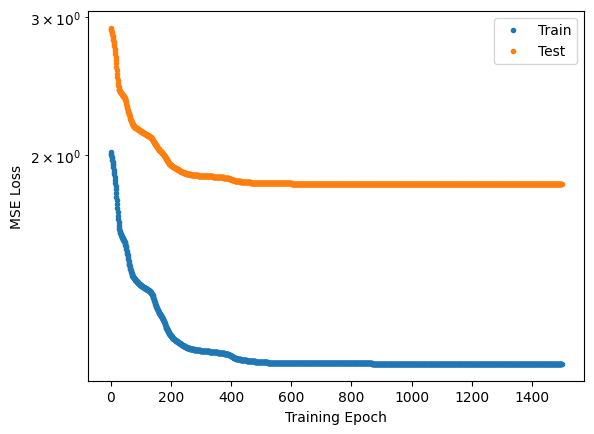

In [13]:
# plot the losses vs epoch
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log')

A helper function to retrieve the individual event-wise losses from the sample (`getLosses`) 

In [14]:
net.eval()
def getLosses(sample):
    losses=[]
    for i in range(len(sample)):
        pred = net(sample[i])
        loss = loss_fn(pred, sample[i])
        losses.append(loss.data.item())
    return losses

0.0012949886731803417
78.28262329101562


Text(0, 0.5, 'Entries/Bin')

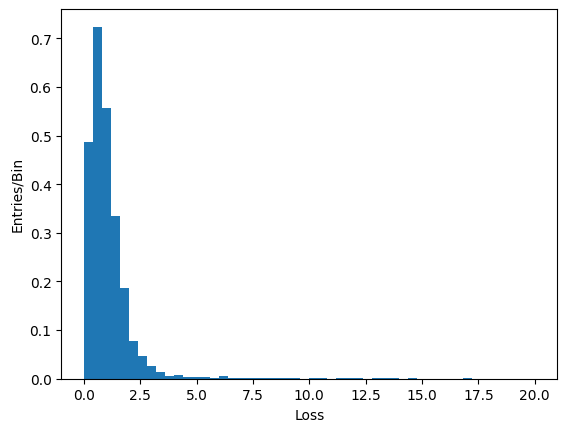

In [15]:
# get the training dataset losses and plot them
train_loss = getLosses(train)

print(np.min(train_loss))
print(np.max(train_loss))
plt.hist(train_loss,bins=50,range=(0, 20), label="Training losses", density=True)
plt.xlabel("Loss");
plt.ylabel("Entries/Bin")

0.001604796969331801
163.21688842773438


Text(0, 0.5, 'Entries/Bin')

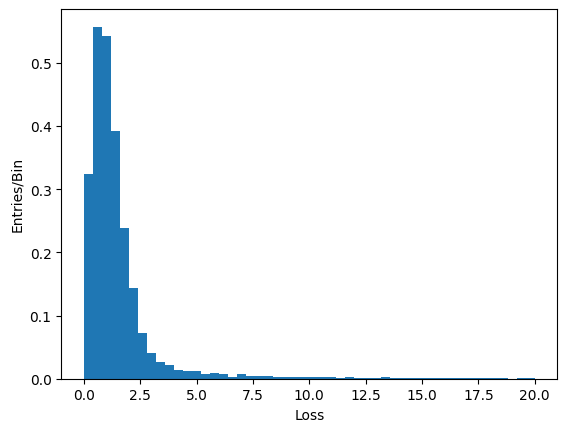

In [16]:
# get the test dataset losses and plot them

test_loss = getLosses(test)

print(np.min(test_loss))
print(np.max(test_loss))
plt.hist(test_loss,bins=50,range=(0, 20), label="Training losses", density=True)
plt.xlabel("Loss");
plt.ylabel("Entries/Bin")

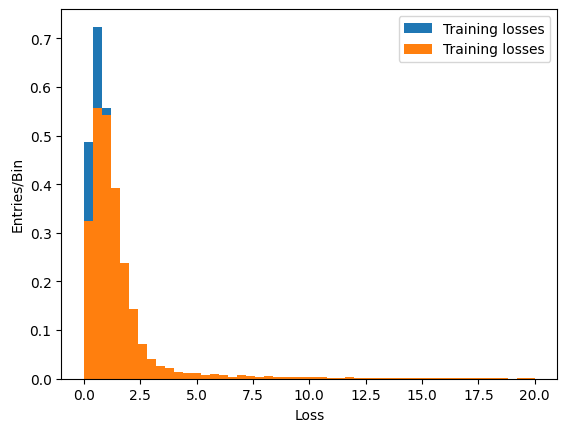

In [17]:
# make a single plot overlaying the training and test dataset losses, 
# with each normalized so they both have unit area.

plt.hist(train_loss,bins=50,range=(0, 20), label="Training losses", density=True)
plt.xlabel("Loss");
plt.ylabel("Entries/Bin")

plt.hist(test_loss,bins=50,range=(0, 20), label="Training losses", density=True)
plt.xlabel("Loss");
plt.ylabel("Entries/Bin")

plt.legend()